# Model evaluation notebook

in this notebook we will evaluate % availability. definitions are:

X = hour, dow, weekend, holiday, is_sunny, caiso, site_id
y = % available (for site)

this will work for all sites.

How will we do train test split?
random 80-20 for now 


In [1]:
import os
if 'models' == os.getcwd().split('/')[-1]: os.chdir('..')
if 'ev_charging' == os.getcwd().split('/')[-1]: print('in the right place!')
else: os.chdir('/Users/varunvenkatesh/Documents/Github/ev_charging')
os.getcwd()

in the right place!


'/home/denny/Documents/mids/ev_charging'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from src.data_preprocessing import  datetime_processing, userinput_processing, holiday_processing, create_all_site_x, create_all_site_y, create_x, update_varuns_x, get_start_end_times

In [3]:
df_c = pd.read_parquet('data/sessions/caltech/').reset_index(drop=True)
df_c = datetime_processing(df_c)
df_c = userinput_processing(df_c)

df_j = pd.read_parquet('data/sessions/jpl/').reset_index(drop=True)
df_j = datetime_processing(df_j)
df_j = userinput_processing(df_j)

df_o = pd.read_parquet('data/sessions/office001/').reset_index(drop=True)
df_o = datetime_processing(df_o)
df_o = userinput_processing(df_o)

cols = list(df_c.columns)
df = pd.concat([df_c[cols], df_j[cols], df_o[cols]], axis=0)

In [4]:
print(f'df is a dataframe comprised of these site ids: {list(df.siteID.unique())}')

df is a dataframe comprised of these site ids: [2, 1, 19]


# Make X and y

In [5]:
start = '2018-05-01'
end = '2021-09-13'
spaceID = 'CA-303'
caiso_fp = 'data/caiso_dataset_5min.csv'
sun_fp = 'data/ct_sr_ss.csv'

In [6]:
X = pd.DataFrame()
sites_df = [df_o,df_c,df_j]
site_ids = [2,1,19]
caiso_fp = 'data/caiso_dataset_5min.csv'


for sdf, id, sun_fp in zip(sites_df, site_ids, ['data/of_sr_ss.csv','data/ct_sr_ss.csv', 'data/jpl_sr_ss.csv'] ):
    start, end = get_start_end_times(sdf)
    tmpx = create_x(start, end, caiso_fp, sun_fp)
    tmpx = update_varuns_x(tmpx, id)
    
    if X.empty:
        X = tmpx
    else:
        X = pd.concat([X, tmpx], axis=0)
    

/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:203: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['date'] + ' ' + sun['sunset'], errors='coerce', utc=True)
/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:203: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['date'] + ' ' + sun['sunset'], errors='coerce', utc=True)
/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:203: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['d

In [7]:
X['siteID'].value_counts().sum() == X.shape[0]
print(f'there are {X.shape[0]} records')

there are 77715 records


# Deal with covid
we found (graphically) that covid effects start around march 3rd 2020, so we truncated our data to march 1st. Since we did not have dates that contained post covid data, we did not include any charges after 2020-03-01 

In [8]:
x = X[X.index < '2020-03-01']
x.index.max()


Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [9]:
cols = list(df_c.columns)
df = pd.concat([df[cols] for df in sites_df], axis=0)
y = create_all_site_y(df, regression=True)

In [10]:
assert X.shape[0] == y.shape[0], 'X and y rows are not equal!'

In [11]:
y = y[y.index < '2020-03-01']
y.index.max()

Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [12]:
assert x.shape[0] == y.shape[0], 'forgot to trim y\'s covid!'

In [13]:
y.shape

(37320,)

In [14]:
x.shape

(37320, 29)

# Modeling
In this section we will compare 

- linear regression models
- XGBoost regression, and 
- LSTM

models using the evaluation metric of RMSE

## LR

In [15]:
x.columns
cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]
x[cat_cols]

,dow,hour,month,is_sunny,is_holiday,siteID
2019-03-25 00:00:00+00:00,0,0,3,0,False,2
2019-03-25 01:00:00+00:00,0,1,3,0,False,2
2019-03-25 02:00:00+00:00,0,2,3,0,False,2
2019-03-25 03:00:00+00:00,0,3,3,0,False,2
2019-03-25 04:00:00+00:00,0,4,3,0,False,2
...,...,...,...,...,...,...
2020-02-29 19:00:00+00:00,5,19,2,0,False,19
2020-02-29 20:00:00+00:00,5,20,2,0,False,19
2020-02-29 21:00:00+00:00,5,21,2,0,False,19
2020-02-29 22:00:00+00:00,5,22,2,0,False,19


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


linear_regression_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('lr', LinearRegression()),
        ]
)

linear_regression_model.fit(X_train, y_train)

print(f'training RMSE: {np.sqrt(mean_squared_error(linear_regression_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(linear_regression_model.predict(X_test), y_test))}')
print(f'training R2: {linear_regression_model.score(X_train, y_train)}\ntest R2    : {linear_regression_model.score(X_test, y_test)}')
r2_score(linear_regression_model.predict(X_train), y_train)

training RMSE: 0.1923608289371932
test RMSE    : 0.19347094991343797
training R2: 0.5362147691054747
test R2    : 0.5387446988615864


0.1350756122062412

Text(0, 0.5, '% available')

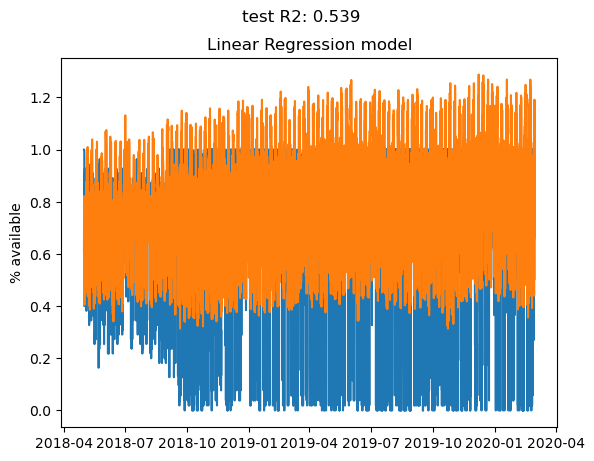

In [17]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(linear_regression_model.predict(X_test), index=X_test.index)
plt.title('Linear Regression model')
plt.suptitle(f'test R2: {np.round(linear_regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

# XGBoost

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


xgb_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('xgb', XGBRegressor()),
        ]
)

xgb_model.fit(X_train, y_train)
print(f'training RMSE: {np.sqrt(mean_squared_error(xgb_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(xgb_model.predict(X_test), y_test))}')
print(f'training r2: {xgb_model.score(X_train, y_train)}\ntest r2    : {xgb_model.score(X_test, y_test)}')

training RMSE: 0.07881203658373331
test RMSE    : 0.10123842455071375
training r2: 0.9226985258394843
test r2    : 0.8700272902220924


Text(0, 0.5, '% available')

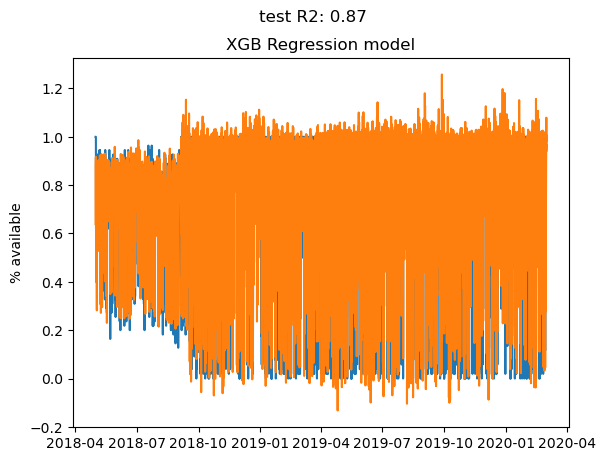

In [19]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(xgb_model.predict(X_test), index=X_test.index)
plt.title('XGB Regression model')
plt.suptitle(f'test R2: {np.round(xgb_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

# LSTM

In [24]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
tf.random.set_seed(42)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

X_train_1 = pd.DataFrame(numeric_transformer.fit_transform(X_train[num_cols]))
X_train_2 = pd.DataFrame(categorical_transformer.fit_transform(X_train[cat_cols]))
X_train_enc = pd.concat([X_train_1, X_train_2], axis=1)
X_train_enc = np.reshape(X_train_enc.values.astype(float), (X_train_enc.shape[0], 1, X_train_enc.shape[1]))

def create_lstm():
    model = Sequential()
    model.add(LSTM(7, input_shape=(1, X_train_enc.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='selu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

lstm_regression_model = create_lstm()
lstm_regression_model.fit(X_train_enc, y_train, epochs=10, batch_size=8, verbose=2)

# print(f'training RMSE: {np.sqrt(mean_squared_error(lstm_regression_model.predict(X_train_enc), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(lstm_regression_model.predict(X_test_enc), y_test))}')
#print(f'training loss: {regression_model.score(X_train, y_train)}\ntest loss    : {regression_model.score(X_test, y_test)}')

Epoch 1/10


/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3732/3732 - 4s - 1ms/step - loss: 0.0463
Epoch 2/10
3732/3732 - 3s - 916us/step - loss: 0.0200
Epoch 3/10
3732/3732 - 4s - 972us/step - loss: 0.0159
Epoch 4/10
3732/3732 - 5s - 1ms/step - loss: 0.0147
Epoch 5/10
3732/3732 - 5s - 1ms/step - loss: 0.0139
Epoch 6/10
3732/3732 - 4s - 944us/step - loss: 0.0130
Epoch 7/10
3732/3732 - 3s - 798us/step - loss: 0.0128
Epoch 8/10
3732/3732 - 3s - 803us/step - loss: 0.0123
Epoch 9/10
3732/3732 - 3s - 796us/step - loss: 0.0119
Epoch 10/10
3732/3732 - 3s - 847us/step - loss: 0.0116


In [21]:
X_test = X_test.sort_index()
X_test_1 = pd.DataFrame(numeric_transformer.transform(X_test[num_cols]))
X_test_2 = pd.DataFrame(categorical_transformer.transform(X_test[cat_cols]))
X_test_enc = pd.concat([X_test_1, X_test_2], axis=1)
X_test_enc = np.reshape(X_test_enc.values.astype(float), (X_test_enc.shape[0], 1, X_test_enc.shape[1]))

In [22]:
from sklearn.metrics import r2_score
print(f'training RMSE: {np.sqrt(mean_squared_error(lstm_regression_model.predict(X_train_enc), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(lstm_regression_model.predict(X_test_enc), y_test))}')
print(f'training r2: {r2_score(y_train,lstm_regression_model.predict(X_train_enc))}\ntest r2    : {r2_score(y_test, lstm_regression_model.predict(X_test_enc))}')

933/933 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
training RMSE: 0.09459112073662024
test RMSE    : 0.3891238729058221
933/933 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
training r2: 0.8873842058396951
test r2    : -0.8367856963758624


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0, 0.5, '% available')

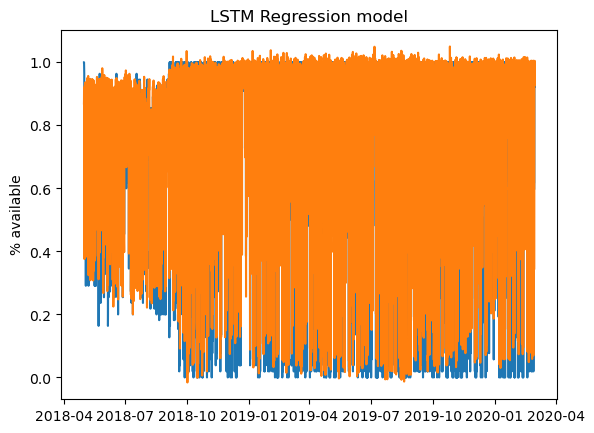

In [23]:
y_test = y_test.sort_index()
pred = lstm_regression_model.predict(X_test_enc)
plt.title('LSTM Regression model')
#plt.suptitle(f'test R2: {np.round(regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')